In [39]:
from experiments.mnli_utils import *
from experiments.mnli import main, plot_Xs_and_Ys_dict
from experiments.mnli import *

In [40]:
task_tokenizer, task_model = create_tokenizer_and_model(
    "/export/home/Experiments/20200706/")

imitator_tokenizer, imitator_model = create_tokenizer_and_model(
    "/export/home/Experiments/20200718/output_dir/")

train_dataset, eval_dataset = create_datasets(tokenizer=task_tokenizer)

Params Trainable: 14768643
	bert.encoder.layer.10.attention.self.query.weight
	bert.encoder.layer.10.attention.self.query.bias
	bert.encoder.layer.10.attention.self.key.weight
	bert.encoder.layer.10.attention.self.key.bias
	bert.encoder.layer.10.attention.self.value.weight
	bert.encoder.layer.10.attention.self.value.bias
	bert.encoder.layer.10.attention.output.dense.weight
	bert.encoder.layer.10.attention.output.dense.bias
	bert.encoder.layer.10.attention.output.LayerNorm.weight
	bert.encoder.layer.10.attention.output.LayerNorm.bias
	bert.encoder.layer.10.intermediate.dense.weight
	bert.encoder.layer.10.intermediate.dense.bias
	bert.encoder.layer.10.output.dense.weight
	bert.encoder.layer.10.output.dense.bias
	bert.encoder.layer.10.output.LayerNorm.weight
	bert.encoder.layer.10.output.LayerNorm.bias
	bert.encoder.layer.11.attention.self.query.weight
	bert.encoder.layer.11.attention.self.query.bias
	bert.encoder.layer.11.attention.self.key.weight
	bert.encoder.layer.11.attention.self.ke

In [41]:
imitator_model.cuda()
print(task_model.training, imitator_model.training)
print(task_model.device, imitator_model.device)

False False
cpu cuda:0


In [42]:
from transformers import glue_output_modes, TrainingArguments, glue_compute_metrics

output_mode = glue_output_modes["mnli"]
def build_compute_metrics_fn(task_name: str):
    def compute_metrics_fn(p):
        if output_mode == "classification":
            preds = np.argmax(p.predictions, axis=1)
        elif output_mode == "regression":
            preds = np.squeeze(p.predictions)
        return glue_compute_metrics(task_name, preds, p.label_ids)

    return compute_metrics_fn


trainer = Trainer(
    model=task_model,
    args=TrainingArguments(output_dir="./tmp-output", per_device_train_batch_size=128, per_device_eval_batch_size=128, learning_rate=5e-5, logging_steps=100),
    data_collator=default_data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=build_compute_metrics_fn("mnli"),
)

train_batch_data_loader = get_dataloader(
    train_dataset,
    batch_size=128,
    data_collator=default_data_collator)

train_instance_data_loader = get_dataloader(
    train_dataset,
    batch_size=1,
    data_collator=default_data_collator)

eval_instance_data_loader = get_dataloader(
    eval_dataset,
    batch_size=1,
    data_collator=default_data_collator)

You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


In [8]:
outputs_collections = main(
    label_list=train_dataset.label_list,
    task_model=task_model,
    imitator_model=imitator_model,
    trainer=trainer,
    batch_train_data_loader=train_batch_data_loader,
    instance_train_data_loader=train_instance_data_loader,
    instance_eval_data_loader=eval_instance_data_loader,
    test_data_point_indices=[3, 14, 15, 24, 25, 29, 31, 32, 38, 41][5:],
    finetune_using_ground_truth_label=False)

Loaded FAISS index with 392702 entries


814.60 | 1.48: : 502it [05:13,  1.60it/s]                        
100%|██████████| 50/50 [01:46<00:00,  2.13s/it]


#1/1: Elapsed 12.39
Loaded FAISS index with 392702 entries


49.64 | 0.02: : 502it [05:13,  1.60it/s]                        
100%|██████████| 50/50 [01:37<00:00,  1.96s/it]


#2/2: Elapsed 12.24


In [37]:
from experiments.mnli import sort_dict_keys_by_vals, TRAIN_INPUT_COLLECTIONS_PATH
from experiments.mnli_utils import visualize

In [131]:
sorted_indices = sort_dict_keys_by_vals(outputs_collections_0_4[2]["influences"])

In [132]:
sorted_indices[-1], outputs_collections_0_4[2]["index"]

(124822, 15)

In [133]:
# train_inputs_collections = torch.load(
#     TRAIN_INPUT_COLLECTIONS_PATH)

In [138]:
for i, test_inputs in enumerate(eval_instance_data_loader):
    if i == 7:
        logits, labels, step_eval_loss = predict(
            trainer=trainer, model=task_model, inputs=test_inputs)
        break

In [139]:
decode_one_example(
    tokenizer=task_tokenizer,
    label_list=train_dataset.label_list,
    inputs=test_inputs,
    logits=torch.from_numpy(logits))

("[CLS] Calcutta seems to be the only other production center having any pretensions to artistic creativity at all, but ironically you're actually more likely to see the works of Satyajit Ray or Mrinal Sen shown in Europe or North America than in India itself. [SEP] Most of Mrinal Sen's work can be found in European collections. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]",
 'neutral',
 'neutral')

In [140]:
visualize(
    tokenizer=task_tokenizer,
    label_list=train_dataset.label_list,
    inputs=test_inputs)

	P: Calcutta seems to be the only other production center having any pretensions to artistic creativity at all, but ironically you're actually more likely to see the works of Satyajit Ray or Mrinal Sen shown in Europe or North America than in India itself.
	H: Most of Mrinal Sen's work can be found in European collections.
	L: neutral


In [144]:
visualize(tokenizer=task_tokenizer,
          label_list=train_dataset.label_list,
          inputs=train_inputs_collections[5])

	P: my walkman broke so i'm upset now i just have to turn the stereo up real loud
	H: I'm upset that my walkman broke and now I have to turn the stereo up really loud.
	L: entailment


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict

In [16]:
# torch.save(outputs_collections, "/export/home/Experiments/20200722/outputs_collections.0-5.right.generated-label.pt")

outputs_collections_0_4 = torch.load("/export/home/Experiments/20200722/outputs_collections.0-5.wrong.ground-truth-label.pt")
outputs_collections_5_9 = torch.load("/export/home/Experiments/20200722/outputs_collections.6-10.wrong.ground-truth-label.pt")
# outputs_collections_0_4 = torch.load("/export/home/Experiments/20200722/outputs_collections.0-5.wrong.generated-label.pt")
# outputs_collections_5_9 = torch.load("/export/home/Experiments/20200722/outputs_collections.6-10.wrong.generated-label.pt")
# outputs_collections_0_4 = torch.load("/export/home/Experiments/20200722/outputs_collections.0-5.right.ground-truth-label.pt")
# outputs_collections_5_9 = torch.load("/export/home/Experiments/20200722/outputs_collections.0-5.right.generated-label.pt")

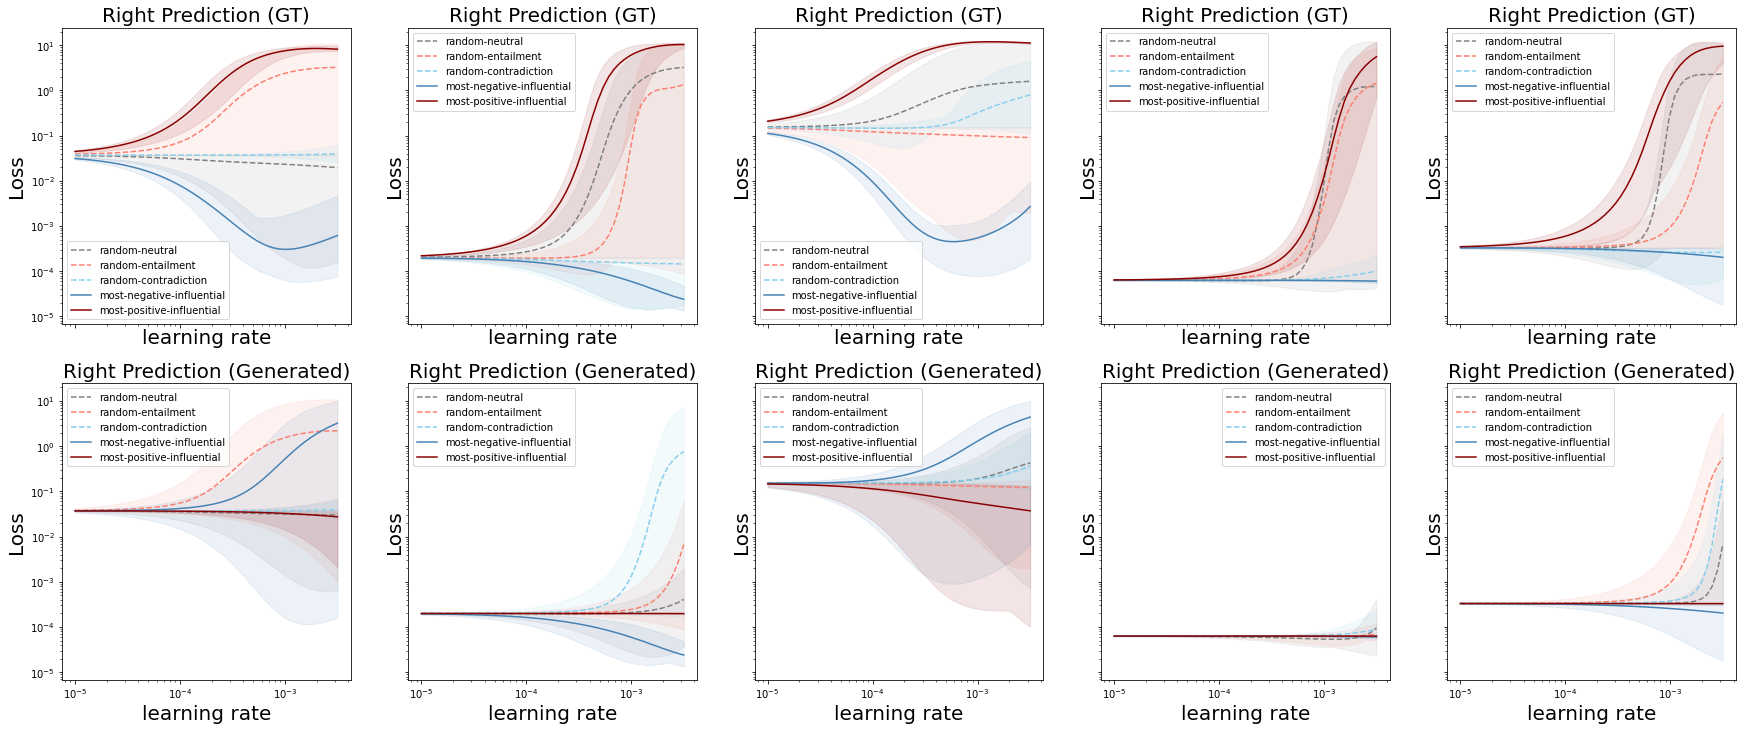

In [10]:
plt.rcParams["figure.figsize"] = (30, 12)
figure, axes = plt.subplots(2, 5, sharex=True, sharey=True)
for i in range(len(outputs_collections_0_4)):
    _plot_Xs_and_Ys_dict(
        axis=axes[0, i],
        fontsize=20,
        title="Right Prediction (GT)",
        Xs=np.logspace(-5, -2.5, 50),
        Ys_dict=outputs_collections_0_4[i]["losses"])

for i in range(len(outputs_collections_5_9)):
    _plot_Xs_and_Ys_dict(
        axis=axes[1, i],
        fontsize=20,
        title="Right Prediction (Generated)",
        Xs=np.logspace(-5, -2.5, 50),
        Ys_dict=outputs_collections_5_9[i]["losses"])
    

figure.savefig("./20200722-imitator-0-5-right-gt-and-generated.pdf")

In [3]:
def _plot_Xs_and_Ys_dict(
        axis,
        title: str,
        fontsize: int,
        Xs: List[float],
        Ys_dict: Dict[str, List[List[float]]]
) -> None:
    # plt.rcParams["figure.figsize"] = (10, 10)
    color_map = {
        "random-neutral": "grey",
        "random-entailment": "salmon",
        "random-contradiction": "skyblue",
        "most-positive-influential": "darkred",
        "most-negative-influential": "steelblue"}

    legends = []
    for tag in Ys_dict.keys():
        if tag not in color_map.keys():
            raise ValueError

        legends.append(tag)
        color = color_map[tag]
        data = np.array(Ys_dict[tag])
        is_random_data_point = "random" in tag

        if data.shape[0] != 1:
            data_mean = data.mean(axis=0)
            data_max = data.max(axis=0)
            data_min = data.min(axis=0)
            # data_std = data.std(axis=0)
            axis.plot(Xs, data_mean,
                     color=color,
                     linestyle=("--" if is_random_data_point else None))

            # plt.fill_between(Xs,
            #                  data_mean + 1. * data_std,
            #                  data_mean - 1. * data_std,
            #                  color=color,
            #                  alpha=0.1 if is_random_data_point else 0.2)
            axis.fill_between(Xs, data_max, data_min,
                             alpha=0.1,
                             color=color)
        else:
            plt.plot(Xs, data[0, ...], color=color)

    axis.set_xscale("log")
    axis.set_yscale("log")
    axis.set_xlabel("learning rate", fontsize=fontsize)
    axis.set_ylabel("Loss", fontsize=fontsize)
    axis.legend(legends, fontsize=fontsize // 2)
    axis.set_title(title, fontsize=fontsize)
    # plt.savefig("./20200719-fig1.pdf")
